In [28]:
"""
Analysis and Visualization of Attack Results

This script:
  1. Loads the attack results and raw generations from JSON files.
  2. Computes summary statistics for key metrics (zlib_ratio, min_window_ppl, avg_window_ppl).
  3. Plots:
       - Histogram of zlib_ratio values.
       - Histogram of min-window perplexity values.
       - A scatter plot of zlib_ratio vs. min-window perplexity.
       - A bar chart of the top 10 most frequent prompts.
  4. Checks if any verified memorized examples were found; if none, it prints additional statistics
     and suggests possible reasons (e.g. high perplexity, low overlap with corpus).
  5. Saves the graphs and a JSON summary of the analysis.
  
Dependencies:
  - matplotlib
  - numpy
  - json, os, statistics, collections
"""

import os
import json
import statistics
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# CONFIGURATION: Update these file names if needed.
OUTPUT_GENERATIONS = "../bioGPT_attack/Run5/biogpt_new_generations.json"
ATTACK_RESULTS_FILE = "../bioGPT_attack/Run5/attack_results_unified_fuzzy.json"
ANALYSIS_RESULTS_FILE = "analysis_results.json"
ANALYSIS_SUMMARY_FILE = "analysis_summary.json"

In [20]:
def load_json(path: str):
    if not os.path.exists(path):
        print(f"[ERROR] File not found: {path}")
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def analyze_metric(data, metric):
    values = [entry[metric] for entry in data if entry.get(metric) is not None]
    if not values:
        return None
    stats = {
        "count": len(values),
        "min": min(values),
        "max": max(values),
        "mean": statistics.mean(values),
        "median": statistics.median(values),
        "stdev": statistics.stdev(values) if len(values) > 1 else 0
    }
    return stats

def compute_prompt_distribution(data):
    prompts = [entry["prompt"] for entry in data if entry.get("prompt")]
    return dict(Counter(prompts))

def find_outliers(data, metric, threshold_std=1.0, high=True):
    """
    Identify potential outlier completions where the metric is more than threshold_std standard deviations
    above (if high=True) or below (if high=False) the mean.
    """
    values = [entry[metric] for entry in data if entry.get(metric) is not None]
    if not values:
        return []
    mean_val = statistics.mean(values)
    stdev_val = statistics.stdev(values) if len(values) > 1 else 0
    if high:
        outliers = [entry for entry in data if entry.get(metric, 0) > mean_val + threshold_std * stdev_val]
    else:
        outliers = [entry for entry in data if entry.get(metric, 0) < mean_val - threshold_std * stdev_val]
    return outliers

In [21]:
generations = load_json(OUTPUT_GENERATIONS)
attack_results = load_json(ATTACK_RESULTS_FILE)
if generations is None:
    print("[ERROR] Could not load generation data.")
print("=== Analysis of Attack Pipeline Results ===")
print(f"Total generations: {len(generations)}")
# Compute summary statistics for key metrics.
metrics = ["zlib_ratio", "min_window_ppl", "avg_window_ppl"]
metric_stats = {}
for m in metrics:
    stats = analyze_metric(generations, m)
    metric_stats[m] = stats
    if stats:
        print(f"Metric '{m}': count = {stats['count']}, min = {stats['min']:.3f}, max = {stats['max']:.3f}, "
              f"mean = {stats['mean']:.3f}, median = {stats['median']:.3f}, stdev = {stats['stdev']:.3f}")
    else:
        print(f"No data for metric '{m}'.")

=== Analysis of Attack Pipeline Results ===
Total generations: 2000
Metric 'zlib_ratio': count = 2000, min = 1.759, max = 4.215, mean = 2.189, median = 2.164, stdev = 0.183
Metric 'min_window_ppl': count = 2000, min = 1.375, max = 12.900, mean = 3.814, median = 3.442, stdev = 1.496
Metric 'avg_window_ppl': count = 2000, min = 5.462, max = 247.295, mean = 18.597, median = 17.370, stdev = 8.440



In [36]:
zlib_ratios = [entry["zlib_ratio"] for entry in generations if "zlib_ratio" in entry]
min_ppls = [entry["min_window_ppl"] for entry in generations if entry.get("min_window_ppl") is not None]
avg_ppls = [entry["avg_window_ppl"] for entry in generations if entry.get("avg_window_ppl") is not None]
prompts = [entry["prompt"] for entry in generations if "prompt" in entry]

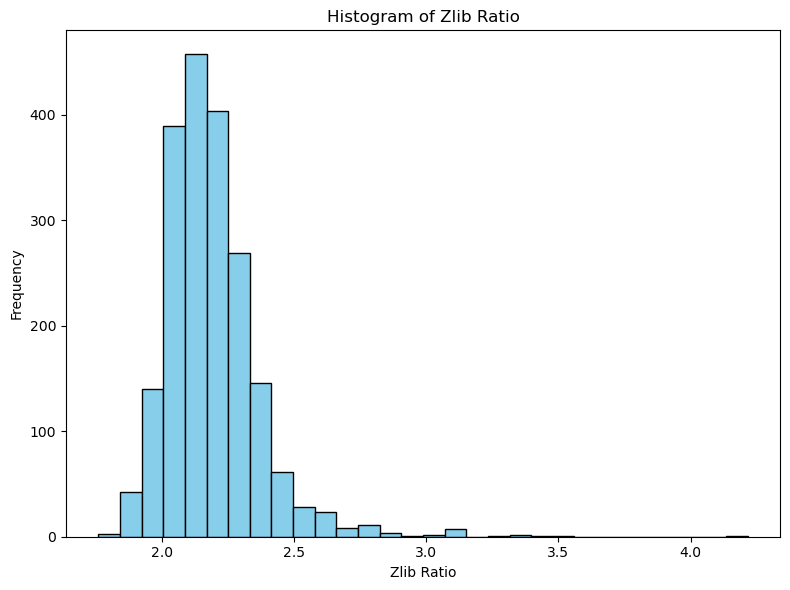

In [35]:
# Plot 1: Histogram of zlib_ratio
plt.figure(figsize=(8,6))
plt.hist(zlib_ratios, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Zlib Ratio")
plt.xlabel("Zlib Ratio")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("hist_zlib_ratio.png")
plt.show()

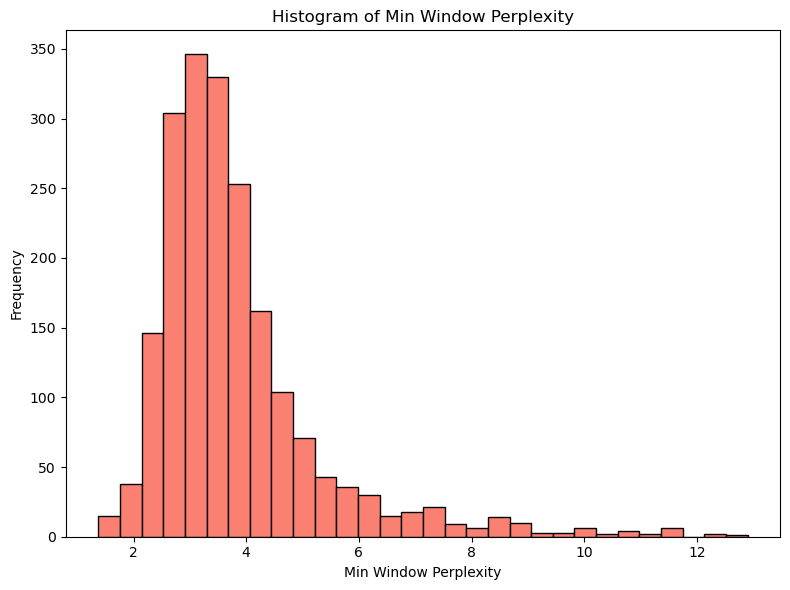

In [38]:
# Plot 2: Histogram of min_window_ppl
plt.figure(figsize=(8,6))
plt.hist(min_ppls, bins=30, color='salmon', edgecolor='black')
plt.title("Histogram of Min Window Perplexity")
plt.xlabel("Min Window Perplexity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("hist_min_window_ppl.png")
plt.show()

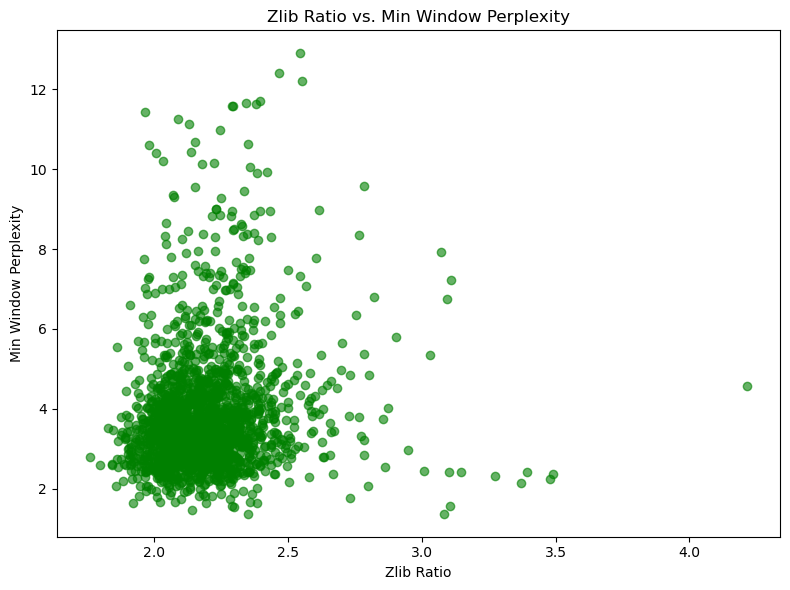

In [39]:
# Plot 3: Scatter plot of zlib_ratio vs min_window_ppl
plt.figure(figsize=(8,6))
plt.scatter(zlib_ratios, min_ppls, alpha=0.6, color='green')
plt.title("Zlib Ratio vs. Min Window Perplexity")
plt.xlabel("Zlib Ratio")
plt.ylabel("Min Window Perplexity")
plt.tight_layout()
plt.savefig("scatter_zlib_vs_minppl.png")
plt.show()

In [22]:
# Analyze prompt distribution.
prompt_dist = compute_prompt_distribution(generations)
sorted_prompts = sorted(prompt_dist.items(), key=lambda x: x[1], reverse=True)
print("Top 5 most common prompts:")
for prompt, freq in sorted_prompts[:5]:
    print(f"  '{prompt}' -> {freq} occurrences")

Top 5 most common prompts:
  'qualitative assessment of the application of a discrete choice experiment with community health workers in uganda: aligning incentives with preferences.' -> 2 occurrences
  'large-scale and flexible self-powered triboelectric tactile sensing array for sensitive robot skin.' -> 2 occurrences
  'no guidelines exist regarding physicians' duty to inform former patients about novel genetic tests that may be medically beneficial. research' -> 2 occurrences
  'in apparent contrast to its invasive potential staphylococcus aureus colonizes the anterior nares of 20-80% of the human population. the' -> 2 occurrences
  'healthy physical coactivity in parent-child dyads of children with overweight.' -> 2 occurrences


In [23]:
# Identify potential outliers.
outliers_zlib = find_outliers(generations, "zlib_ratio", threshold_std=1.0, high=True)
outliers_low_ppl = find_outliers(generations, "min_window_ppl", threshold_std=1.0, high=False)
print(f"Potential outlier completions based on high zlib_ratio: {len(outliers_zlib)}")
print(f"Potential outlier completions based on low min_window_ppl: {len(outliers_low_ppl)}")


Potential outlier completions based on high zlib_ratio: 211
Potential outlier completions based on low min_window_ppl: 101


In [24]:
# For each outlier, print a summary (limit to first 5 for brevity).
print("Sample outlier completions based on high zlib_ratio:")
for i, entry in enumerate(outliers_zlib[:5], start=1):
    print(f"Outlier {i}:")
    print(f"  Prompt: {entry['prompt']}")
    print(f"  zlib_ratio: {entry['zlib_ratio']:.3f}, min_window_ppl: {entry['min_window_ppl']}, avg_window_ppl: {entry['avg_window_ppl']}")
    print(f"  Generated (first 150 chars): {entry['generated_text'][:150]}...")
    print("-" * 60)

Sample outlier completions based on high zlib_ratio:
Outlier 1:
  Prompt: selective cell-surface expression of triheteromeric nmda receptors.
  zlib_ratio: 2.436, min_window_ppl: 5.857901573181152, avg_window_ppl: 16.7399595896403
  Generated (first 150 chars): selective cell-surface expression of triheteromeric nmda receptors. At negative V for activation that was chosen so current activation for NMDA and fo...
------------------------------------------------------------
Outlier 2:
  Prompt: the application of artificial neural networks in the detection of mandibular fractures using panoramic radiography.
  zlib_ratio: 2.405, min_window_ppl: 3.533226728439331, avg_window_ppl: 11.567934719721476
  Generated (first 150 chars): the application of artificial neural networks in the detection of mandibular fractures using panoramic radiography. Ninety mandibular fractures were i...
------------------------------------------------------------
Outlier 3:
  Prompt: this paper investigated the 

In [25]:
print("Sample outlier completions based on low min_window_ppl:")
for i, entry in enumerate(outliers_low_ppl[:5], start=1):
    print(f"Outlier {i}:")
    print(f"  Prompt: {entry['prompt']}")
    print(f"  zlib_ratio: {entry['zlib_ratio']:.3f}, min_window_ppl: {entry['min_window_ppl']}, avg_window_ppl: {entry['avg_window_ppl']}")
    print(f"  Generated (first 150 chars): {entry['generated_text'][:150]}...")
    print("-" * 60)

Sample outlier completions based on low min_window_ppl:
Outlier 1:
  Prompt: environmentally stable and multi-functional conductive gelatin/pva/black wattle bark tannin based organogel as strain, temperature and bioelectric sensor for multi-mode sensing.
  zlib_ratio: 2.054, min_window_ppl: 2.0484328269958496, avg_window_ppl: 26.05588300526142
  Generated (first 150 chars): environmentally stable and multi-functional conductive gelatin / pva / black wattle bark tannin based organogel as strain, temperature and bioelectric...
------------------------------------------------------------
Outlier 2:
  Prompt: the branched chains and branching degree of exopolysaccharides affecting the stability of anammox granular sludge.
  zlib_ratio: 2.063, min_window_ppl: 2.24697208404541, avg_window_ppl: 13.54614184697469
  Generated (first 150 chars): the branched chains and branching degree of exopolysaccharides affecting the stability of anammox granular sludge. Furthermore by comparing this case ..

In [26]:
# If attack_results includes verified memorized completions, analyze them.
verified = attack_results.get("verified_memorized", [])
print(f"Verified memorized completions (from attack results): {len(verified)}")
if verified:
    for i, entry in enumerate(verified[:5], start=1):
        print(f"Verified {i}:")
        print(f"  Prompt: {entry['prompt']}")
        print(f"  zlib_ratio: {entry['zlib_ratio']:.3f}, min_window_ppl: {entry['min_window_ppl']}, avg_window_ppl: {entry['avg_window_ppl']}")
        print(f"  Generated (first 150 chars): {entry['generated_text'][:150]}...")
        print("-" * 60)

Verified memorized completions (from attack results): 0


In [27]:
# Save analysis results
analysis_results = {
    "metric_stats": metric_stats,
    "prompt_distribution": sorted_prompts[:10],
    "outliers_high_zlib": outliers_zlib,
    "outliers_low_ppl": outliers_low_ppl,
    "verified_memorized": verified
}
with open(ANALYSIS_RESULTS_FILE, "w", encoding="utf-8") as af:
    json.dump(analysis_results, af, indent=2)
print(f"[INFO] Analysis results saved to {ANALYSIS_RESULTS_FILE}")

[INFO] Analysis results saved to analysis_results.json
